# Imports

In [191]:
import torch, random, math
import torch.nn.functional as F
from torch import nn
from torchtext import data
from torch.autograd import Variable
from iseq2seq.utils import load_anki_dataset, masked_cross_entropy

import matplotlib.pyplot as plt
%matplotlib inline

# Loading data

In [2]:
data_path = 'data/dataset.pkl'
ds_train, ds_test, ES, EN = load_anki_dataset(data_path)

train_buckets = data.BucketIterator(ds_train, 32,
    sort_key=lambda x: data.interleave_keys(len(x.es), len(x.en)))
test_buckets = data.BucketIterator(ds_test, 500,
    sort_key=lambda x: data.interleave_keys(len(x.es), len(x.en)))
train_iter = iter(train_buckets)
test_iter = iter(test_buckets)
x_train = next(train_iter)
x_test = next(test_iter)
x_train.es.size(), x_train.en.size(), x_test.es.size(), x_test.en.size()



    Only loading the 'es' tokenizer.



    Only loading the 'en' tokenizer.



(torch.Size([6, 32]),
 torch.Size([8, 32]),
 torch.Size([7, 500]),
 torch.Size([11, 500]))

In [3]:
train_max_length = 0

for ex in train_buckets.dataset.examples:
    train_max_length = max(train_max_length, len(ex.en))
    
train_max_length

53

In [4]:
SOS_token = EN.vocab.stoi['<sos>']
EOS_token = EN.vocab.stoi['<eos>']
SOS_token, EOS_token

(2, 3)

# Encoder

In [25]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, bidirectional=False,
                 embedding_dropout=0, rnn_dropout=0):
        super(EncoderRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.bidirectional = bidirectional
        self.embedding_dropout = embedding_dropout
        self.rnn_dropout = rnn_dropout
        
        # Layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.embedding_dropout = nn.Dropout(embedding_dropout)
        self.rnn = nn.GRU(hidden_size, hidden_size, num_layers=n_layers,
                          bidirectional=bidirectional, dropout=rnn_dropout)
        
    def forward(self, input, hidden):
        embs = self.embedding(input)
        embs = self.embedding_dropout(embs)
        output, hidden = self.rnn(embs, hidden)
        if self.bidirectional:
            # En caso el encoder sea bidireccional, se suman los outputs
            # en vez de concatenarlos.
            output = output[:, :, :self.hidden_size] + output[:, : ,self.hidden_size:]
        
        return output, hidden

# Attention Decoder

In [26]:
class Attention(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attention, self).__init__()
        self.method = method
        self.hidden_size = hidden_size
        
        # metodos definidos en https://arxiv.org/pdf/1508.04025.pdf
        assert method in ('dot', 'general', 'concat'), 'invalid attention method'
        
        # Layers
        if self.method == 'general':
            self.att = nn.Linear(self.hidden_size, hidden_size)

        elif self.method == 'concat':
            self.att = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(1, hidden_size))

    def forward(self, hidden, encoder_outputs):
        max_len = encoder_outputs.size(0)
        this_batch_size = encoder_outputs.size(1)

        # Se inicializa las energias de atencion y se calculan en cada elemento del batch
        att_energies = Variable(torch.zeros(this_batch_size, max_len)).cuda()

        for b in range(this_batch_size): # por cada elemento b del batch
            for i in range(max_len): # por cada paso i de la secuencia
                att_energies[b, i] = self.score(hidden[:, b].squeeze(0),
                                                encoder_outputs[i, b])

        # Se normalizan los pesos entre 0 y 1
        return F.softmax(att_energies).unsqueeze(1)
    
    def score(self, hidden, encoder_output):
        if self.method == 'dot':
            energy = hidden.dot(encoder_output)
            return energy
        
        elif self.method == 'general':
            energy = self.att(encoder_output)
            energy = hidden.dot(energy)
            return energy
        
        elif self.method == 'concat':
            energy = self.att(torch.cat((hidden, encoder_output), 1))
            energy = self.v.dot(energy)
            return energy

class AttnDecoderRNN(nn.Module):
    def __init__(self, output_size, hidden_size, n_layers=1,
                 att_method='general', embedding_dropout=0, rnn_dropout=0):
        super(AttnDecoderRNN, self).__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.att_method = att_method
        self.embedding_dropout = embedding_dropout
        self.rnn_dropout = rnn_dropout

        # Layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.embedding_dropout = nn.Dropout(embedding_dropout)
        self.rnn = nn.GRU(hidden_size, hidden_size, n_layers, dropout=rnn_dropout)
        self.attention = Attention(att_method, hidden_size)
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, last_hidden, encoder_outputs):
        # ojo: input es el batch de los ultimos outputs, no es una secuencia
        batch_size = input.size(0)
        embs = self.embedding(input)
        embs = self.embedding_dropout(embs)
        embs = embs.view(1, batch_size, self.hidden_size)

        # Se corre la RNN en el input con el ultimo hidden state
        rnn_output, hidden = self.rnn(embs, last_hidden)
        
        # Se calcula la atencion y se aplica a las salidas del encoder
        att_weights = self.attention(rnn_output, encoder_outputs)
        context = att_weights.bmm(encoder_outputs.transpose(0, 1))
        
        # Se concatenan los valores de salida de la rnn y el contexto
        concat_input = torch.cat((rnn_output.squeeze(0), context.squeeze(1)), 1)
        concat_output = F.tanh(self.concat(concat_input))
        output = self.out(concat_output)

        return output, hidden, att_weights
    

# Training

In [188]:
def train_epoch(encoder, decoder, encoder_optimizer, decoder_optimizer, gradient_clip=5.0):
    # Inicializar gradientes y perdida
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Obtener batch de entrenamiento
    training_batch = next(train_iter)
    input_variable = training_batch.es
    target_variable = training_batch.en
    input_length, batch_size  = input_variable.size()
    target_length = target_variable.size()[0]

    # Encodear el input
    encoder_outputs, encoder_hidden = encoder(input_variable, None)

    # Crear variables para el input y output del decoder
    decoder_input = Variable(torch.LongTensor([SOS_token] * batch_size)).cuda()
    # decoder_hidden = encoder_hidden[:decoder.n_layers]
    decoder_hidden = encoder_hidden[-decoder.n_layers:]
    all_decoder_outputs = Variable(torch.zeros(target_length, batch_size, decoder.output_size)).cuda()

    # Se ejecuta el decoder en cada paso de la secuencia
    for t in range(target_length):
        decoder_output, decoder_hidden, decoder_att = decoder(
            decoder_input, decoder_hidden, encoder_outputs
        )

        all_decoder_outputs[t] = decoder_output

        if t < target_length-1:
            # Usar teacher_forcing
            use_tf = random.random() < tf_ratio
            if use_tf:
                # De la data
                decoder_input = target_variable[t+1]
            else:
                # Del modelo
                decoder_input = decoder_output.topk(1, 1)[1]

    log_probs = F.log_softmax(all_decoder_outputs.view(-1, decoder.output_size))
    loss = nn.NLLLoss()(log_probs, target_variable.view(-1))
    loss.backward()

    # Clip gradient norms
    nn.utils.clip_grad_norm(encoder.parameters(), gradient_clip)
    nn.utils.clip_grad_norm(decoder.parameters(), gradient_clip)

    # Update parameters with optimizers
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.data[0]

In [189]:
def train(encoder, decoder, encoder_optimizer, decoder_optimizer, epochs=10,
          gradient_clip=5.0):
    results = {}
    train_loss = []
    zeros = int(math.log10(epochs)) + 1
    
    for i in range(epochs):
        print(f'{i+1:0{zeros}}/{epochs}...', end='\r')
        l = train_epoch(encoder, decoder, encoder_optimizer, decoder_optimizer, gradient_clip)
        train_loss.append(l)
        # TODO: evaluate loss
        # TODO: show results
    
    results['train_loss'] = train_loss
    
    return results

In [151]:
encoder_hidden = 256
encoder_bi = True
n_layers = 2
teacher_forcing_ratio = 0.5
lr = 0.0001

encoder = EncoderRNN(len(ES.vocab.itos), encoder_hidden, n_layers, bidirectional=encoder_bi).cuda()
decoder = AttnDecoderRNN(len(EN.vocab.itos), encoder_hidden, n_layers).cuda()
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)

In [190]:
results = train(encoder, decoder, encoder_optimizer, decoder_optimizer, epochs=20)

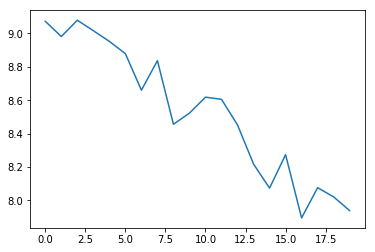

In [195]:
plt.plot(results['train_loss']);